<a href="https://colab.research.google.com/github/maxvell07/TelecomLabs/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Проведём импорт необходимых библиотек и файлов:

In [34]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

# **Упражнение 9.1**

Блокнот для этой главы - `chap09.ipynb`. Прочитайте его и запустите код.

В разделе "Нарастающая сумма" на стр. 119 отмечено, что некоторые примеры не работают с апериодическими сигналами. Замените периодический пилообразный сигнал на непериодические данные Facebook и посмотрите, что пойдёт не так.


In [35]:
if not os.path.exists('FB_2.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv

In [36]:
import pandas as pd

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
len(df)

1977

In [37]:
from thinkdsp import Wave

ys = df['Close']

# for these examples, we need the wave to have
# an even number of samples
if len(ys) % 2:
    ys = ys[:-1]

close = Wave(ys, framerate=1)
len(close)

1976

Построим временной ряд и его спектр:

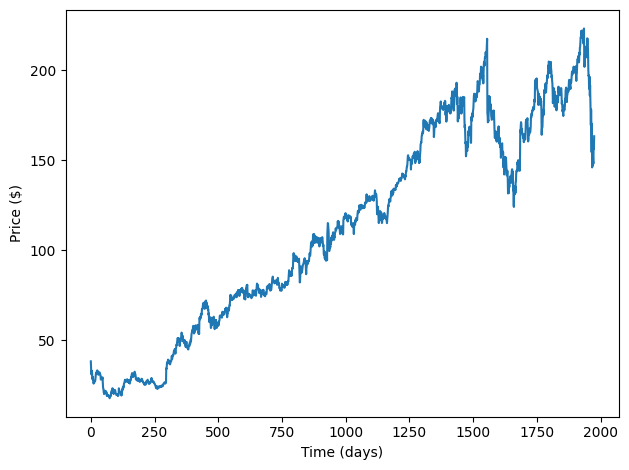

In [38]:
close.plot()
decorate(xlabel='Time (days)', ylabel='Price ($)')

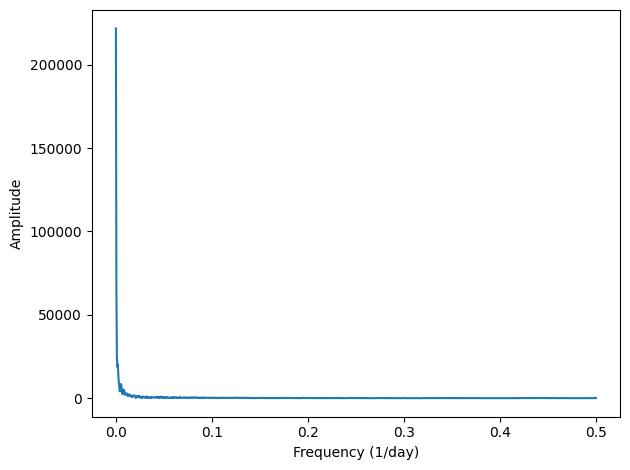

In [39]:
close_spectrum = close.make_spectrum()
close_spectrum.plot()
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude')

Выходная волна - это нарастающая сумма входных сигналов. Также вычислим спектр.

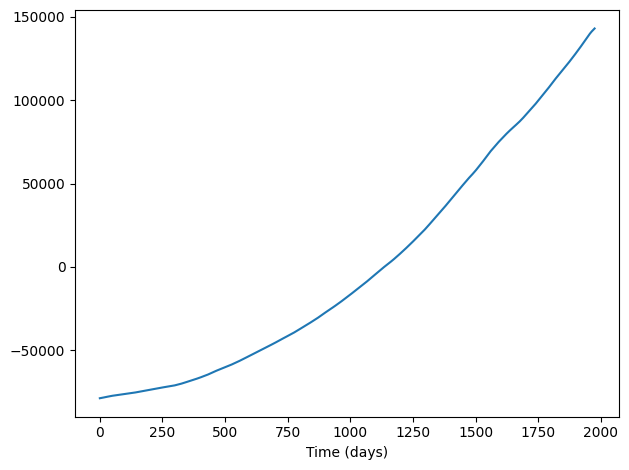

In [40]:
out_wave = close.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (days)')

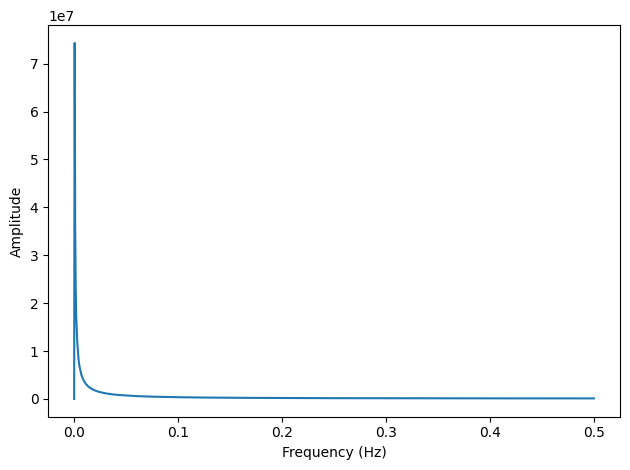

In [41]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Вычислим отношение выходных данных к входным:

In [42]:
sum(close_spectrum.amps < 1), len(close_spectrum)

(0, 989)

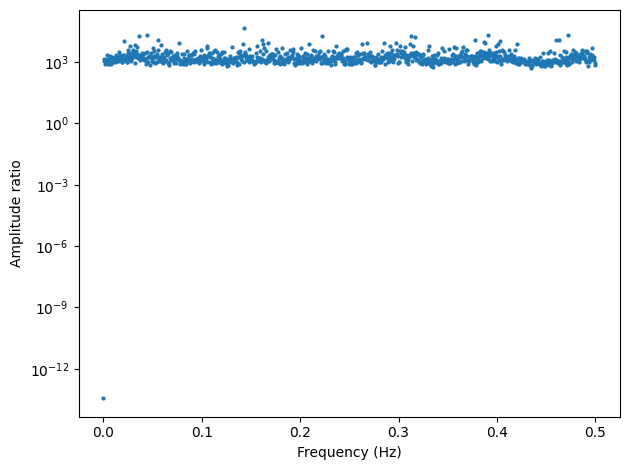

In [43]:
ratio_spectrum = out_spectrum.ratio(close_spectrum, thresh=1)
ratio_spectrum.plot(marker='.', ms=4, ls='')

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

In [44]:
from thinkdsp import zero_pad
# compute the diff filter
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(close))
diff_wave = Wave(padded, framerate=close.framerate)
diff_filter = diff_wave.make_spectrum()

In [45]:
# compute the cumsum filter by inverting the diff filter
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf

In [46]:
# compute the integration filter
integ_filter = cumsum_filter.copy()
integ_filter.hs[1:] = integ_filter.framerate / (np.pi*2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

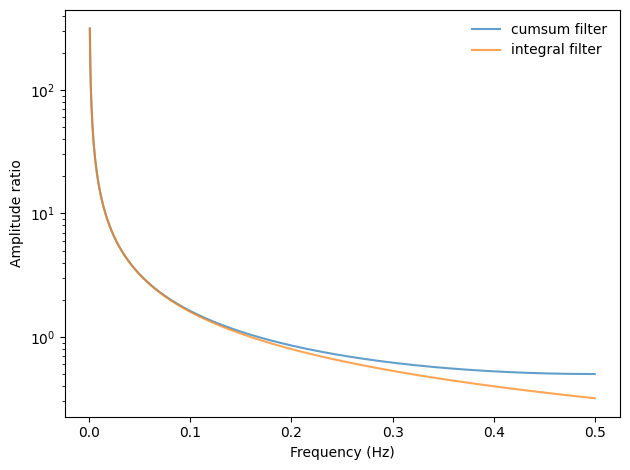

In [47]:
cumsum_filter.plot(label='cumsum filter', alpha=0.7)
integ_filter.plot(label='integral filter', alpha=0.7)

decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

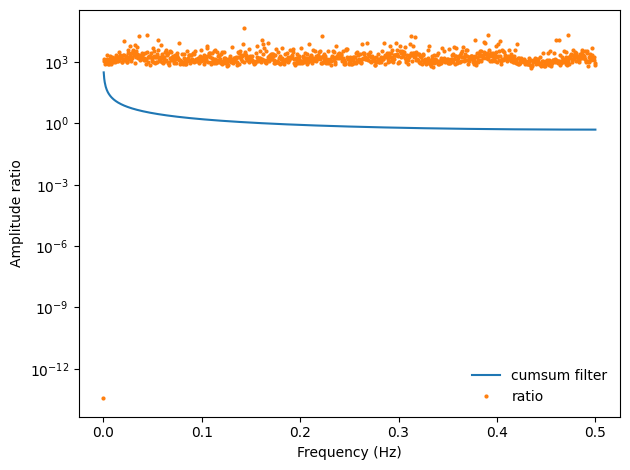

In [48]:
cumsum_filter.plot(label='cumsum filter')
ratio_spectrum.plot(label='ratio', marker='.', ms=4, ls='')
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude ratio',
         yscale='log')

Теперь мы можем вычислить выходную волну, используя теорему о свертке, и сравнить результаты:

In [49]:
len(close_spectrum), len(cumsum_filter)

(989, 989)

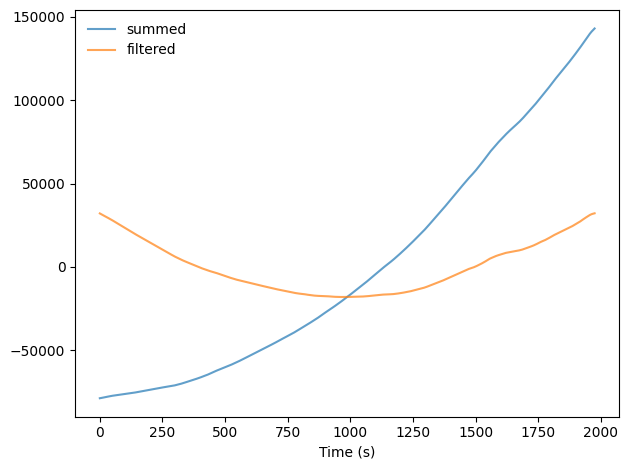

In [50]:
out_wave.plot(label='summed', alpha=0.7)

cumsum_filter.hs[0] = 0
out_wave2 = (close_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='filtered', alpha=0.7)

decorate(xlabel='Time (s)')

In [51]:
out_wave.max_diff(out_wave2)

110808.40936477095

Результаты практически противоположные.

# **Упражнение 9.2**

В этом упражнение изучается влияение `diff` и `differentiate` на сигнал. Создайте треугольный сигнал и напечатайте его. Примените `diff` к сигналу и напечатайте результат. Вычислите спектр треугольного сигнала, примените `differentiate` и напечатайте результат. Преобразуйте спектр обратно в сигнал и напечатайте его. Есть ли различия в воздействии `diff` и `differentiate` на этот сигнал?

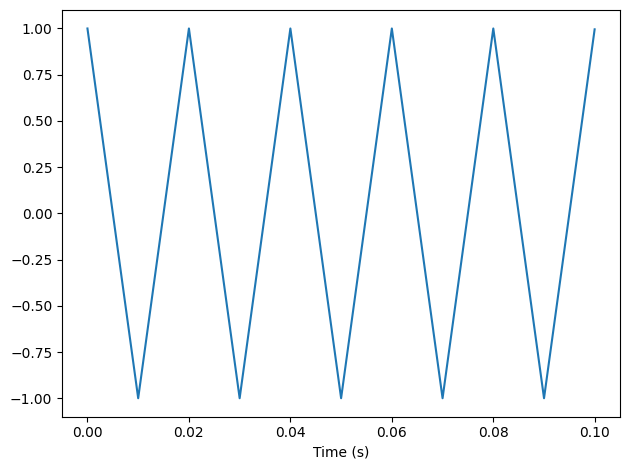

In [52]:
from thinkdsp import TriangleSignal

in_wave = TriangleSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

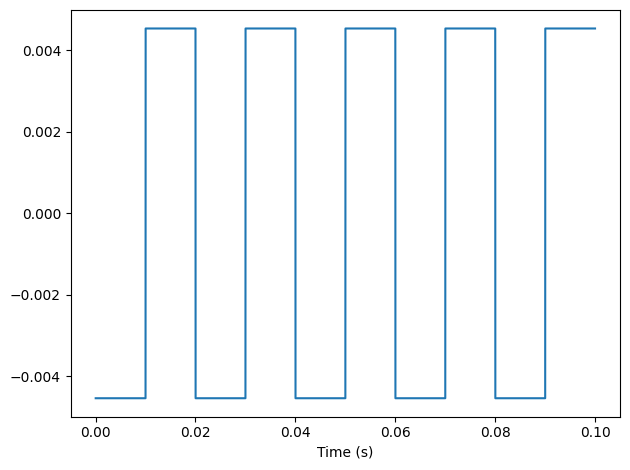

In [53]:
out_wave = in_wave.diff()
out_wave.plot()
decorate(xlabel='Time (s)')

In [54]:
out_wave2 = in_wave.make_spectrum().differentiate().make_wave()


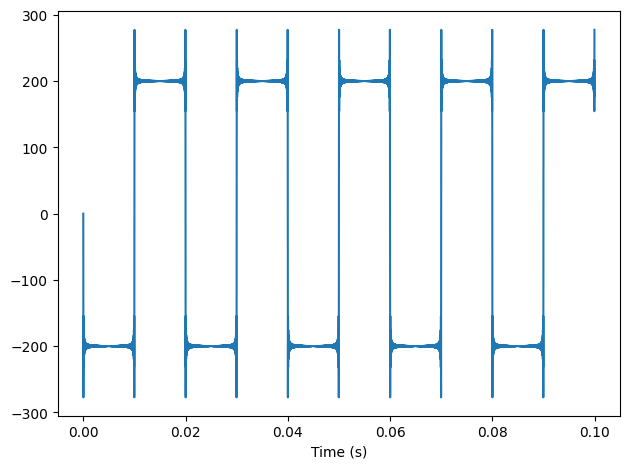

In [55]:
out_wave2.plot()
decorate(xlabel='Time (s)')

Воздействия на треугольный сигнал у этих двух функций действительно разные, так как производная треугольной волны не определена в точках треугольника.

# **Упражнение 9.3**

В данном упражнении изучается влияние `cumsum` и `integrate` на сигнал. Создайте прямоугольный сигнал и напечатайте его. Примените `cumsum` и напечатайте результат. Вычислите спектр прямоугольного сигнала, примените `integrate` и напечатайте результат. Преобразуйте спектр обратно в сигнал и напечатайте его. Есть ли различия в воздействии `cumsum` И `integrate` на этот сигнал?

По сути повторим эксперимент предыдущего упражнения, но с другими функциями:

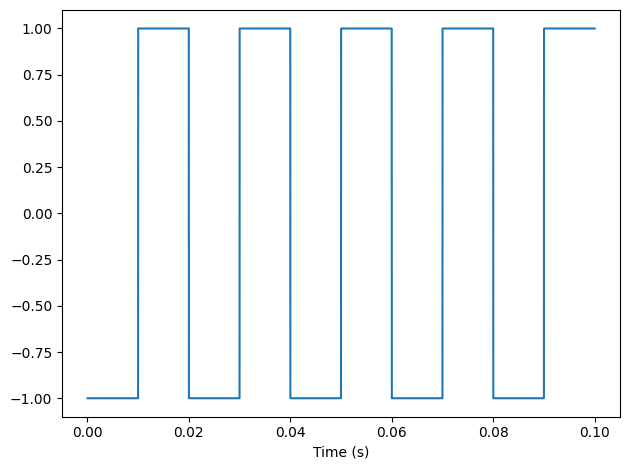

In [56]:
from thinkdsp import SquareSignal

in_wave = SquareSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

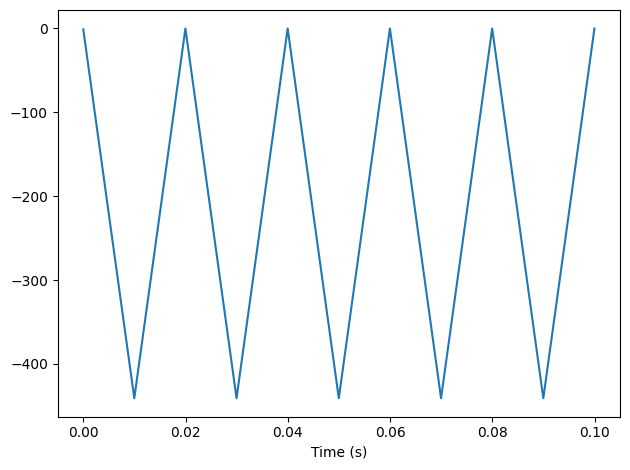

In [57]:
out_wave = in_wave.cumsum()
out_wave.plot()
decorate(xlabel='Time (s)')

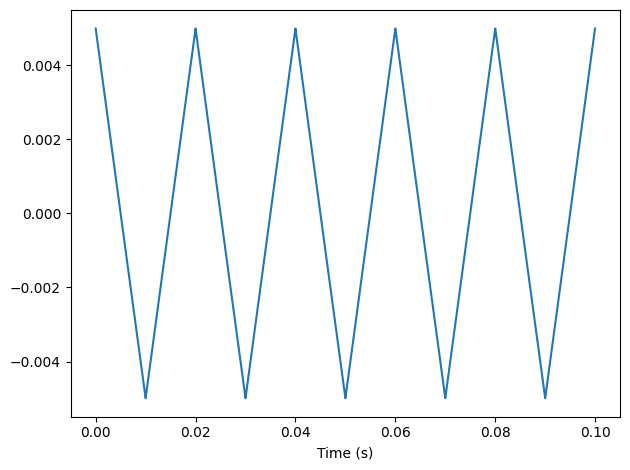

In [58]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

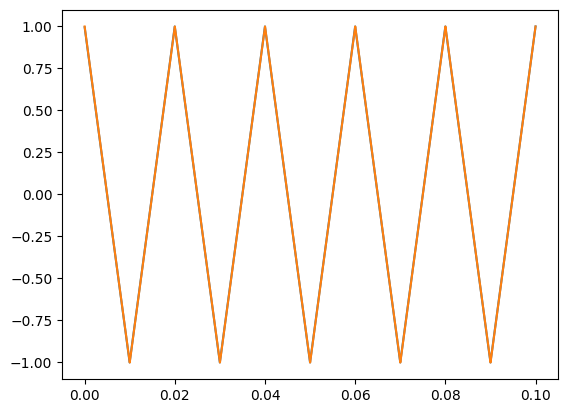

In [59]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()


In [60]:
out_wave.max_diff(out_wave2)

0.0045351473922902175

Результаты очень похожи. Можно смело заявить, что воздействие этих функций незначительно.

# **Упражнение 9.4**

В данном упражнение изучается влияние двойного интегрирования. Создайте пилообразный сигнал, вычилите его спектр, а затем дважды примените `integrate`. Напечатайте результирующий сигнал и его спектр. Какова математическая форма сигнала? Почему он напоминает синусоиду?

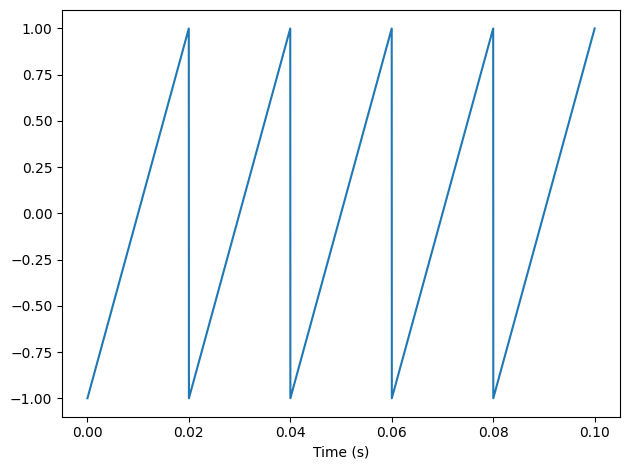

In [62]:
from thinkdsp import SawtoothSignal

in_wave = SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Time (s)')

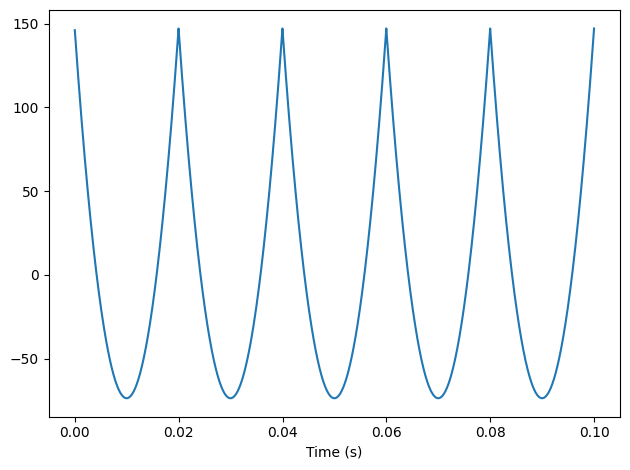

In [63]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Time (s)')

Первая нарастающая сумма пилообразной формы представляет собой параболу.

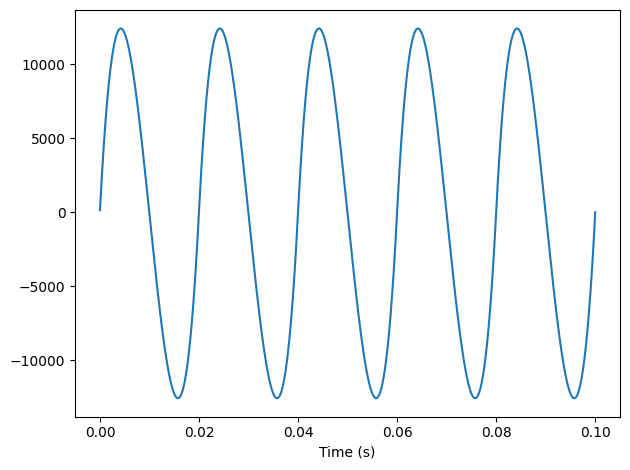

In [64]:
out_wave = out_wave.cumsum()
out_wave.plot()
decorate(xlabel='Time (s)')

Вторая нарастающая сумма - кубическая кривая.

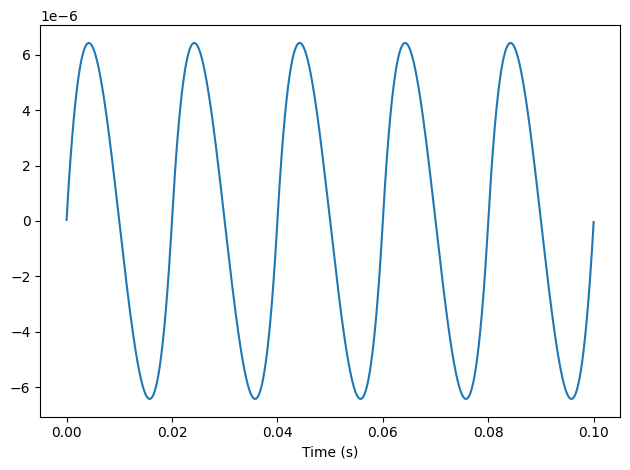

In [65]:
spectrum = in_wave.make_spectrum().integrate().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Двойное интегрирование также предстовляет собой кубическую кривую. На этом этапе результат все больше и больше напоминает синусоиду.

Это происходит из-за того, что интегрирование действует как фильтр нижних частот.

# **Упражнение 9.5**

В этом упражнении изучается влияние второй разности и второй производной. Создайте `CubicSignal`, определенный в `thinkdsp`. Вычислите вторую разность, дважды применив `diff`. Как выглядит результат? Вычислите вторую производную, дважды применив `differentiate` к спектру. Похожи ли результаты?

Распечатайте фильтры, соответствующие второй разнице и второй производной, и сравните их. Подсказка: для того чтобы получить фильтры в одном масштабе, используйте сигнал с частотой кадров 1.

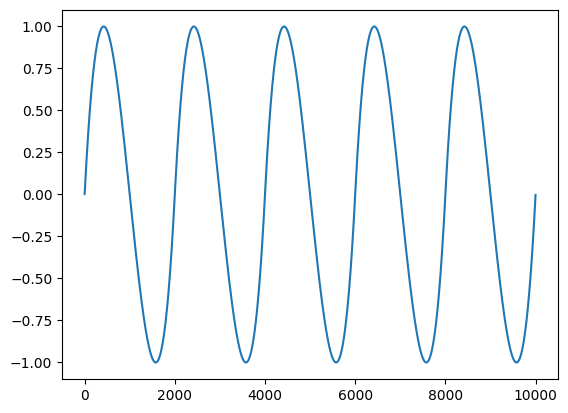

In [66]:
from thinkdsp import CubicSignal

in_wave = CubicSignal(freq=0.0005).make_wave(duration=10000, framerate=1)
in_wave.plot()

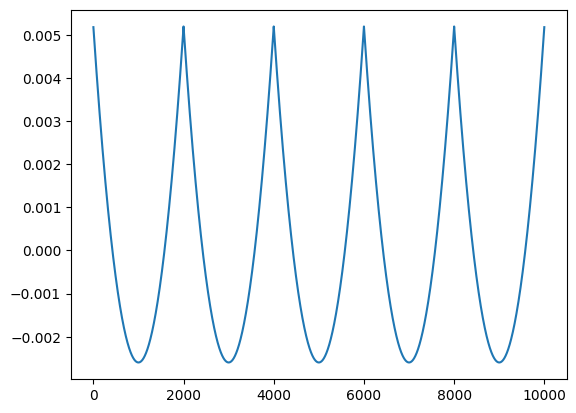

In [67]:
out_wave = in_wave.diff()
out_wave.plot()

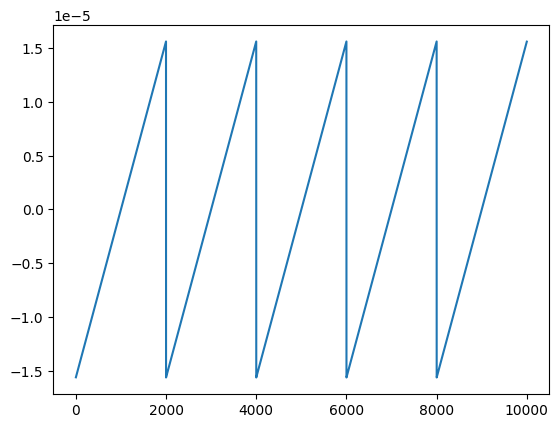

In [68]:
out_wave = out_wave.diff()
out_wave.plot()

Первая разность - парабола, вторая разность - пилообразный сигнал. А вторая производная - пилообразный сигнал с биениями.

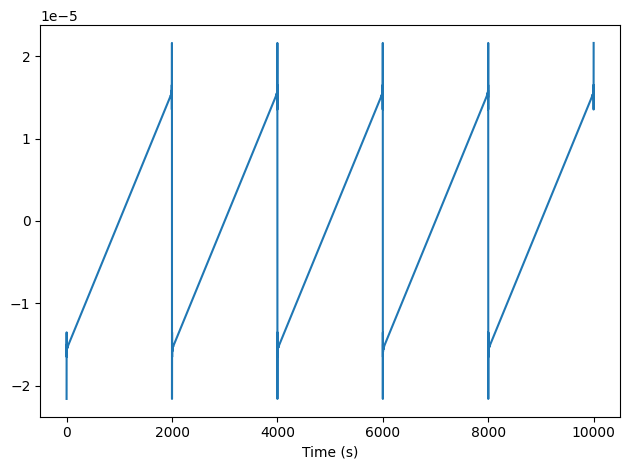

In [69]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

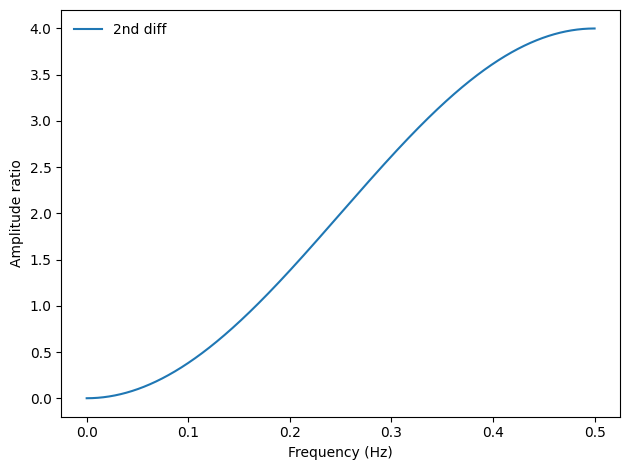

In [70]:
from thinkdsp import zero_pad
from thinkdsp import Wave

diff_window = np.array([-1.0, 2.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
diff_filter.plot(label='2nd diff')

decorate(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio')

Окно второй разности равно -1, 2, -1. Вычисляя DFT окна, мы можем найти соответствующий фильтр.

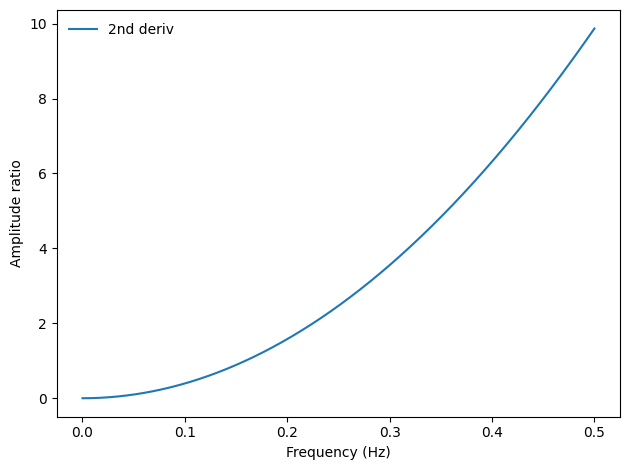

In [71]:
PI2 = np.pi * 2

deriv_filter = in_wave.make_spectrum()
deriv_filter.hs = (PI2 * 1j * deriv_filter.fs)**2
deriv_filter.plot(label='2nd deriv')

decorate(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio')

Для второй прозводной мы можем найти соответствующий фильтр, вычислив фильтр первой производной и возведя его в квадрат. Оба являются фильтрами верхних частот, которые усиливают высокочастотные компоненты.

Вторая производная является параболической, поэтому она сильнее всего усиливает самые высокие частоты. Также она имеет хорошую аппроксимацию только на самых низких частотах, затем оно существенно отклоняется.